# MLP Lesson 2

## Google Cloud Storage Boilerplate

This first cell has some boilerplate to connect the Google Cloud Storage bucket containing the data used for this tutorial to the Google Colab environment. 

In order to access the data for this workshop you'll need to run this cell, follow the link when prompted and copy the Google SDK token into the prompt. If everything works correctly a new folder called `data` should appear in the file browser on the left.

In [1]:
%tensorflow_version 2.x
from google.colab import auth
auth.authenticate_user()

project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'

!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!gcloud config set project {project_id}

!mkdir data
!gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} /content/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0   7867      0 --:--:-- --:--:-- --:--:--  7867
OK
41 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,274 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144439 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.28.1_amd64.deb ...
Unpacking gcsfuse (0.28.1) ...
Setting up gcsfuse (0.28.1) ...
Updated property [core/project].
Using mount point: /content/data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import resample
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
plt.style.use('ggplot')

## Bigger data - deeper networks

The last exercise gave us an intro into how to build and tune some of the parameters of a neural network. Now we move to an example where we have more data. Generally as we increase the amount of training data we can make use of deeper networks, with more layers to give more accurate predictions.

This time around we load up the data from `ag-muon-data-tight.pkl`

Don't forget to take care of class balance in your dataset.

(array([71387.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 71387.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

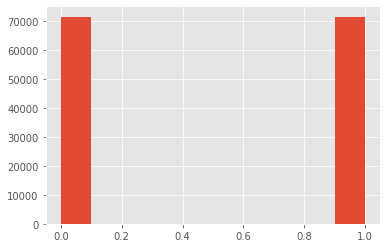

In [3]:
df = pd.read_pickle('/content/data/muon/ag-muon-data-tight.pkl')
X = np.array(df[3].to_list())
y = np.array(df[1].to_list())


num_ag = np.count_nonzero(y==0)
num_no_ag = np.count_nonzero(y==1)

df_majority = df[df[1]==0]
df_minority = df[df[1]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_no_ag,     # to match minority class
                                 random_state=123) # reproducible results

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_new = df_downsampled.sample(frac=1)

X = np.array(df_new[3].to_list())
y = np.array(df_new[1].to_list())
plt.hist(y)

### Initial network

Try re-running your NN from the previous exercise on this new data. **Note** the input vector now has length 1000, rather than 300. See how the network performs. Use the learning rate that you established in the last study.

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
histories = []
#for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
for lr in [1e-3]:
    model5 = Sequential()
    model5.add(Dense(1000, input_dim=1000, activation='relu')) 
    model5.add(BatchNormalization())
    model5.add(Dense(1000, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(128, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(16, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(1, activation='sigmoid'))
    ad = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model5.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
    history = model5.fit(X, y, epochs=30, batch_size=64, validation_split=0.2)
    histories.append(history)

Epoch 1/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.2431 - accuracy: 0.8852 - val_loss: 0.3016 - val_accuracy: 0.8852
Epoch 2/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.1013 - accuracy: 0.9614 - val_loss: 0.0832 - val_accuracy: 0.9708
Epoch 3/30
1785/1785 [==============================] - 9s 5ms/step - loss: 0.0852 - accuracy: 0.9683 - val_loss: 4.4780 - val_accuracy: 0.5049
Epoch 4/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.0762 - accuracy: 0.9720 - val_loss: 0.2063 - val_accuracy: 0.9177
Epoch 5/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.0688 - accuracy: 0.9751 - val_loss: 0.2070 - val_accuracy: 0.9231
Epoch 6/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.0651 - accuracy: 0.9762 - val_loss: 2.9919 - val_accuracy: 0.5351
Epoch 7/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.0589 - accuracy: 0.9793 - val_loss: 0.5985 - val_acc

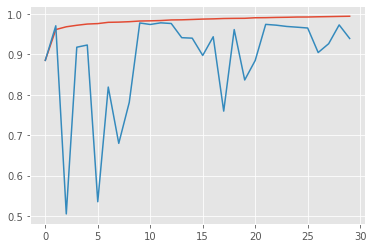

In [5]:
maxs = []
for h in histories:
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    maxs.append(max(h.history['val_accuracy']))

### We're going to need a deeper network!

That looks pretty good! However, since we have so much more data now, we might be tempted to use deeper network with more paramters. Try a network with architecture

    INPUT - 1000 - 1000 - 128 - 16 - OUTPUT
    
For this architecture do the same test for learning rate effects, training for 30 epochs at each learning rate.

In [6]:
histories = []
for lr in [1e-3]:
    model5 = Sequential()
    model5.add(Dense(1000, input_dim=1000, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(1000, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(128, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(16, activation='relu'))
    model5.add(BatchNormalization())
    model5.add(Dense(1, activation='sigmoid'))
    ad = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model5.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
    history = model5.fit(X, y, epochs=30, batch_size=64, validation_split=0.2)
    histories.append(history)

Epoch 1/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.2452 - accuracy: 0.8849 - val_loss: 0.3143 - val_accuracy: 0.8679
Epoch 2/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.1007 - accuracy: 0.9618 - val_loss: 0.0912 - val_accuracy: 0.9672
Epoch 3/30
1785/1785 [==============================] - 10s 5ms/step - loss: 0.0844 - accuracy: 0.9688 - val_loss: 2.1761 - val_accuracy: 0.5386
Epoch 4/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.0749 - accuracy: 0.9728 - val_loss: 2.9780 - val_accuracy: 0.5230
Epoch 5/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.0681 - accuracy: 0.9753 - val_loss: 1.4578 - val_accuracy: 0.6134
Epoch 6/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.0622 - accuracy: 0.9776 - val_loss: 1.6753 - val_accuracy: 0.5833
Epoch 7/30
1785/1785 [==============================] - 10s 6ms/step - loss: 0.0584 - accuracy: 0.9781 - val_loss: 0.3110 - val_ac

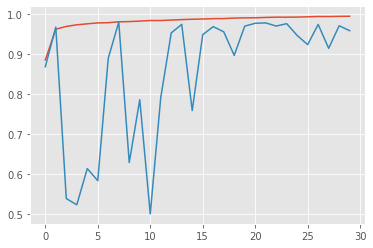

In [8]:
maxs = []
for h in histories:
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    maxs.append(max(h.history['val_accuracy']))

In [9]:
histories[0].history['val_accuracy']

[0.8679040670394897,
 0.9671511054039001,
 0.5385746955871582,
 0.5229907035827637,
 0.6134477257728577,
 0.5833303928375244,
 0.8895114660263062,
 0.9794781804084778,
 0.6285063624382019,
 0.7856767773628235,
 0.5001575946807861,
 0.7906146049499512,
 0.9525477290153503,
 0.9739450216293335,
 0.7583610415458679,
 0.9481351971626282,
 0.9682717323303223,
 0.9554193615913391,
 0.8964805006980896,
 0.9694274067878723,
 0.9766765832901001,
 0.9776221513748169,
 0.9697076082229614,
 0.9757310748100281,
 0.9462090730667114,
 0.9232708811759949,
 0.9738049507141113,
 0.9141306281089783,
 0.9705130457878113,
 0.9582209587097168]